```
Courses: 3
0 824035956565 - Agentic Reasoning | None | ACTIVE
1 793157523744 - Collaborative Filtering | None | ACTIVE
2 838875452113 - DMMRS (Decision Making for Multi-Robot Systems) | None | ACTIVE
```

In [1]:
# !pip -q install \
#   google-api-python-client google-auth google-auth-oauthlib google-auth-httplib2 \
#   pydantic tenacity \
#   langgraph langchain langchain-core \
#   pypdf python-pptx python-docx \
#   requests

In [2]:
import os, json, time, re, io, sqlite3, hashlib
from typing import Any, Dict, List, Optional, Set, Tuple, Literal, Callable

from tenacity import retry, stop_after_attempt, wait_exponential
from pydantic import BaseModel, Field

COURSE_ID = "793157523744"

CREDENTIALS_PATH = "credentials.json"
TOKEN_PATH = "token.json"

DB_PATH = "classroom_agent.sqlite"
CACHE_DIR = "cache_files"
os.makedirs(CACHE_DIR, exist_ok=True)

# ingestion & caching
MAX_PAGES_OR_SLIDES = 100

# summarization
MAX_CHARS = 12000
OVERLAP = 800
MAX_CHUNKS = 6
MAX_COMPLETION_TOKENS = 1500

# retrieval
TOP_K_RETRIEVAL = 5

# digest
LOOKBACK_HOURS_FOR_DIGEST = 12

print("Config loaded.")

Config loaded.


In [3]:

# Embedding model for semantic retrieval (small + fast)
USE_EMBEDDINGS = True
EMBED_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

try:
    from sentence_transformers import SentenceTransformer
    from sklearn.metrics.pairwise import cosine_similarity
    _embedder = SentenceTransformer(EMBED_MODEL_NAME)
except Exception as e:
    USE_EMBEDDINGS = False
    _embedder = None
    print("Embedding model unavailable, falling back to keyword scoring:", e)


def embed_texts(texts: list[str]) -> list[list[float]]:
    if not USE_EMBEDDINGS or _embedder is None:
        return []
    return _embedder.encode(texts, normalize_embeddings=True).tolist()


/opt/anaconda3/envs/classroom-suite/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 2228.18it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [4]:
def log(event: str, **fields):
    payload = {"ts": int(time.time()), "event": event, **fields}
    print(json.dumps(payload, ensure_ascii=False))

def assert_ok(cond: bool, msg: str):
    if not cond:
        raise AssertionError(msg)

log("notebook.start")

{"ts": 1770690504, "event": "notebook.start"}


In [5]:
import os
import warnings
from pathlib import Path
from datetime import datetime

from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from google.auth.transport.requests import Request

def log(msg: str):
    print(f"[{datetime.now().strftime('%H:%M:%S')}] {msg}")

# ✅ Scopes
SCOPES = [
    "https://www.googleapis.com/auth/classroom.courses.readonly",
    "https://www.googleapis.com/auth/classroom.announcements.readonly",
    "https://www.googleapis.com/auth/classroom.courseworkmaterials.readonly",
    "https://www.googleapis.com/auth/classroom.coursework.me.readonly",
    "https://www.googleapis.com/auth/classroom.student-submissions.me.readonly",
    "https://www.googleapis.com/auth/drive.readonly",
    "https://www.googleapis.com/auth/documents",
]

# IMPORTANT: allow oauthlib to accept subset scopes without raising
os.environ["OAUTHLIB_RELAX_TOKEN_SCOPE"] = "1"

def get_creds(CREDENTIALS_PATH: Path, TOKEN_PATH: Path):
    log("Starting OAuth credential loading...")
    log(f"Credentials: {CREDENTIALS_PATH} (exists={CREDENTIALS_PATH.exists()})")
    log(f"Token:       {TOKEN_PATH} (exists={TOKEN_PATH.exists()})")

    if not CREDENTIALS_PATH.exists():
        raise FileNotFoundError(f"Missing {CREDENTIALS_PATH}. Put credentials.json there.")

    # Load existing token if present
    if TOKEN_PATH.exists():
        log("Loading existing token.json...")
        creds = Credentials.from_authorized_user_file(str(TOKEN_PATH), SCOPES)

        log(f"Loaded token. valid={creds.valid}, expired={creds.expired}, has_refresh={bool(creds.refresh_token)}")
        if creds.expired and creds.refresh_token:
            log("Refreshing token...")
            creds.refresh(Request())
            TOKEN_PATH.write_text(creds.to_json())
            log("Token refreshed + saved.")

        log(f"Granted scopes (token): {creds.scopes}")
        return creds

    # Fresh auth
    log("No token found → launching OAuth flow...")
    flow = InstalledAppFlow.from_client_secrets_file(str(CREDENTIALS_PATH), SCOPES)

    # This suppresses the scope-change warning and continues
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Scope has changed.*")
        creds = flow.run_local_server(port=0, open_browser=True, prompt="consent")

    TOKEN_PATH.write_text(creds.to_json())
    log(f"✅ token.json saved at: {TOKEN_PATH}")
    log(f"Granted scopes (auth): {creds.scopes}")

    # Optional: show mismatch without crashing
    req, got = set(SCOPES), set(creds.scopes or [])
    if got and req != got:
        log("⚠️ Scope mismatch (not fatal):")
        log(f"  Requested-only: {sorted(req - got)}")
        log(f"  Granted-only:   {sorted(got - req)}")

    return creds


# ---- Run ----
CREDENTIALS_PATH = Path("credentials.json")
TOKEN_PATH = Path("token.json")

creds = get_creds(CREDENTIALS_PATH, TOKEN_PATH)

log("Building API clients...")
classroom = build("classroom", "v1", credentials=creds)
drive = build("drive", "v3", credentials=creds)
docs = build("docs", "v1", credentials=creds)
log("✅ Clients built.")

[07:58:25] Starting OAuth credential loading...
[07:58:25] Credentials: credentials.json (exists=True)
[07:58:25] Token:       token.json (exists=True)
[07:58:25] Loading existing token.json...
[07:58:25] Loaded token. valid=True, expired=False, has_refresh=True
[07:58:25] Granted scopes (token): ['https://www.googleapis.com/auth/classroom.courses.readonly', 'https://www.googleapis.com/auth/classroom.announcements.readonly', 'https://www.googleapis.com/auth/classroom.courseworkmaterials.readonly', 'https://www.googleapis.com/auth/classroom.coursework.me.readonly', 'https://www.googleapis.com/auth/classroom.student-submissions.me.readonly', 'https://www.googleapis.com/auth/drive.readonly', 'https://www.googleapis.com/auth/documents']
[07:58:25] Building API clients...
[07:58:25] ✅ Clients built.


In [6]:
import os, json, time, sqlite3
from typing import Any, Dict, List, Optional

# ---------- Schemas ----------
EVENTS_SCHEMA = """
CREATE TABLE IF NOT EXISTS events (
  event_id TEXT PRIMARY KEY,
  course_id TEXT NOT NULL,
  event_type TEXT NOT NULL,
  item_id TEXT NOT NULL,
  item_ts INTEGER,
  title TEXT,
  text TEXT,
  raw_json TEXT NOT NULL,
  updated_ts INTEGER NOT NULL
);
CREATE INDEX IF NOT EXISTS idx_events_course_updated ON events(course_id, updated_ts);
"""

MATERIALS_SCHEMA = """
CREATE TABLE IF NOT EXISTS course_materials (
  material_id TEXT PRIMARY KEY,
  course_id TEXT NOT NULL,
  source_type TEXT NOT NULL,
  drive_file_id TEXT,
  url TEXT,
  title TEXT,
  mime_type TEXT,
  md5_checksum TEXT,
  page_or_slide_count INTEGER,
  eligible INTEGER DEFAULT 0,
  status TEXT DEFAULT 'new',
  first_seen_ts INTEGER NOT NULL,
  last_seen_ts INTEGER NOT NULL,
  seen_in_json TEXT,
  summary_v1 TEXT,
  tags_json TEXT
);
CREATE INDEX IF NOT EXISTS idx_materials_course ON course_materials(course_id);
"""

CHECKPOINTS_SCHEMA = """
CREATE TABLE IF NOT EXISTS checkpoints (
  key TEXT PRIMARY KEY,
  value TEXT NOT NULL,
  updated_ts INTEGER NOT NULL
);
"""

def now_ts() -> int:
    return int(time.time())

def init_db():
    con = sqlite3.connect(DB_PATH)
    try:
        con.executescript(EVENTS_SCHEMA)
        con.executescript(MATERIALS_SCHEMA)
        con.executescript(CHECKPOINTS_SCHEMA)
        con.commit()
    finally:
        con.close()
    log(f"db.init db_path={DB_PATH}")

def _db_exec(sql: str, params=()):
    con = sqlite3.connect(DB_PATH)
    try:
        con.execute(sql, params)
        con.commit()
    finally:
        con.close()

def _db_fetchone(sql: str, params=()):
    con = sqlite3.connect(DB_PATH)
    con.row_factory = sqlite3.Row
    try:
        r = con.execute(sql, params).fetchone()
        return dict(r) if r else None
    finally:
        con.close()

def _db_fetchall(sql: str, params=()):
    con = sqlite3.connect(DB_PATH)
    con.row_factory = sqlite3.Row
    try:
        rows = con.execute(sql, params).fetchall()
        return [dict(x) for x in rows]
    finally:
        con.close()

# ----- Internal checkpoint helpers (NOTE: underscore prefix) -----
def _db_set_checkpoint(key: str, value: str):
    _db_exec("""
    INSERT INTO checkpoints(key,value,updated_ts)
    VALUES(?,?,?)
    ON CONFLICT(key) DO UPDATE SET value=excluded.value, updated_ts=excluded.updated_ts
    """, (key, value, now_ts()))

def _db_get_checkpoint(key: str, default: str="0") -> str:
    row = _db_fetchone("SELECT value FROM checkpoints WHERE key=?", (key,))
    return row["value"] if row else default

# Init DB
init_db()
assert_ok(os.path.exists(DB_PATH), "DB file was not created.")
log("sanity.db_ok")

[07:58:25] db.init db_path=classroom_agent.sqlite
[07:58:25] sanity.db_ok


In [7]:

from datetime import datetime, timezone

def parse_due_date(ev: dict):
    due = ev.get("dueDate")
    time = ev.get("dueTime") or {}
    if not due:
        return None
    try:
        dt = datetime(
            due.get("year"), due.get("month"), due.get("day"),
            time.get("hours", 0), time.get("minutes", 0), time.get("seconds", 0),
            tzinfo=timezone.utc
        )
        return dt
    except Exception:
        return None


In [8]:

# DB helpers for materials

def db_upsert_material_from_meta(course_id: str, meta: dict, seen_event_ids: list[str]):
    material_id = f"drive:{meta['id']}"
    now = now_ts()
    seen_json = json.dumps(sorted(set(seen_event_ids)), ensure_ascii=False)

    row = _db_fetchone("SELECT first_seen_ts FROM course_materials WHERE material_id=?", (material_id,))
    first_seen = row["first_seen_ts"] if row else now

    _db_exec("""
    INSERT INTO course_materials(
      material_id, course_id, source_type, drive_file_id, url,
      title, mime_type, md5_checksum,
      page_or_slide_count, eligible, status,
      first_seen_ts, last_seen_ts, seen_in_json,
      summary_v1, tags_json
    )
    VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)
    ON CONFLICT(material_id) DO UPDATE SET
      title=excluded.title,
      mime_type=excluded.mime_type,
      md5_checksum=excluded.md5_checksum,
      last_seen_ts=excluded.last_seen_ts,
      seen_in_json=excluded.seen_in_json
    """, (
        material_id, course_id, "drive_file", meta["id"], None,
        meta.get("name"), meta.get("mimeType"), meta.get("md5Checksum"),
        None, 0, "new",
        first_seen, now, seen_json,
        None, None
    ))
    return material_id


def db_get_all_events(course_id: str):
    return _db_fetchall("SELECT event_id, raw_json, title, text FROM events WHERE course_id=?", (course_id,))


In [9]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

NEMOTRON_MODEL = "nvidia/llama-3.1-nemotron-ultra-253b-v1"

llm = ChatNVIDIA(
    model=NEMOTRON_MODEL,
    temperature=0.2,
)

# sanity: simple invoke
print(llm.invoke("Return ONLY JSON: {\"ok\": true}").content)

{"ok": true}


In [10]:
import re, io, hashlib
from typing import Any, Dict, List, Optional

from langchain_core.tools import tool
from googleapiclient.http import MediaIoBaseDownload, MediaFileUpload
from pypdf import PdfReader
from pptx import Presentation
from docx import Document

URL_RE = re.compile(r"https?://[^\s\)\]]+", re.IGNORECASE)

ALLOWED_MIMES = {
    "application/pdf",
    "application/vnd.openxmlformats-officedocument.presentationml.presentation",
    "application/vnd.ms-powerpoint",
    "application/vnd.openxmlformats-officedocument.wordprocessingml.document",
    "application/msword",
    "application/vnd.google-apps.document",
}

def paginate_list(call_fn, key: str, page_size: int) -> List[Dict[str, Any]]:
    out: List[Dict[str, Any]] = []
    token = None
    while True:
        resp = call_fn(pageSize=page_size, pageToken=token).execute()
        out.extend(resp.get(key, []))
        token = resp.get("nextPageToken")
        if not token:
            break
    return out

def chunk_text(text: str, max_chars: int, overlap: int) -> List[str]:
    if not text:
        return []
    out = []
    i = 0
    n = len(text)
    while i < n:
        j = min(n, i + max_chars)
        out.append(text[i:j])
        if j == n:
            break
        i = max(0, j - overlap)
    return out

def extract_json_block(s: str) -> Optional[Dict[str, Any]]:
    if not s:
        return None
    a = s.find("{")
    b = s.rfind("}")
    if a == -1 or b == -1 or b <= a:
        return None
    cand = s[a:b+1]
    try:
        return json.loads(cand)
    except Exception:
        return None

def nonempty(x: Optional[str]) -> bool:
    return bool(x and x.strip())

def cache_path_for_drive(file_id: str, mime_type: str) -> str:
    if mime_type == "application/pdf":
        ext = ".pdf"
    elif mime_type == "application/vnd.google-apps.document":
        ext = ".gdoc.pdf"
    elif "presentation" in mime_type or mime_type == "application/vnd.ms-powerpoint":
        ext = ".pptx"
    elif "wordprocessingml" in mime_type or mime_type == "application/msword":
        ext = ".docx"
    else:
        ext = ".bin"
    return os.path.join(CACHE_DIR, f"{file_id}{ext}")

# -----------------------
# Classroom tools
# -----------------------

@tool
def classroom_list_announcements(course_id: str, page_size: int = 50) -> str:
    """List announcements for a course. Returns JSON string."""
    items = paginate_list(
        lambda pageSize, pageToken=None: classroom.courses().announcements().list(
            courseId=course_id, pageSize=pageSize, pageToken=pageToken
        ),
        "announcements",
        page_size
    )
    return json.dumps({"announcements": items}, ensure_ascii=False)

@tool
def classroom_list_coursework(course_id: str, page_size: int = 50) -> str:
    """List courseWork for a course. Returns JSON string."""
    items = paginate_list(
        lambda pageSize, pageToken=None: classroom.courses().courseWork().list(
            courseId=course_id, pageSize=pageSize, pageToken=pageToken
        ),
        "courseWork",
        page_size
    )
    return json.dumps({"courseWork": items}, ensure_ascii=False)

@tool
def classroom_list_materials(course_id: str, page_size: int = 50) -> str:
    """List courseWorkMaterial for a course. Returns JSON string."""
    items = paginate_list(
        lambda pageSize, pageToken=None: classroom.courses().courseWorkMaterials().list(
            courseId=course_id, pageSize=pageSize, pageToken=pageToken
        ),
        "courseWorkMaterial",
        page_size
    )
    return json.dumps({"courseWorkMaterial": items}, ensure_ascii=False)

# -----------------------
# DB tools (use _db_* helpers)
# -----------------------

@tool
def db_upsert_event(course_id: str, event_type: str, item_obj_json: str) -> str:
    """Upsert a classroom event into SQLite. Returns JSON with event_id."""
    item_obj = json.loads(item_obj_json)
    item_id = item_obj.get("id") or ""
    if not item_id:
        raise ValueError("Event has no id")

    event_id = f"{event_type}:{item_id}"
    title = item_obj.get("title") or ""
    text = item_obj.get("text") or item_obj.get("description") or ""
    raw_json = json.dumps(item_obj, ensure_ascii=False)
    updated = now_ts()

    con = sqlite3.connect(DB_PATH)
    try:
        con.execute("""
        INSERT INTO events(event_id, course_id, event_type, item_id, item_ts, title, text, raw_json, updated_ts)
        VALUES(?,?,?,?,?,?,?,?,?)
        ON CONFLICT(event_id) DO UPDATE SET
          title=excluded.title,
          text=excluded.text,
          raw_json=excluded.raw_json,
          updated_ts=excluded.updated_ts
        """, (event_id, course_id, event_type, item_id, None, title, text, raw_json, updated))
        con.commit()
    finally:
        con.close()

    return json.dumps({"event_id": event_id}, ensure_ascii=False)

@tool
def db_get_recent_events(course_id: str, since_ts: int) -> str:
    """Fetch recent events since timestamp. Returns JSON string."""
    rows = _db_fetchall("""
    SELECT * FROM events WHERE course_id=? AND updated_ts>=? ORDER BY updated_ts DESC
    """, (course_id, since_ts))
    return json.dumps({"events": rows}, ensure_ascii=False)

@tool
def db_get_event(event_id: str) -> str:
    """Get one event by event_id. Returns JSON string."""
    row = _db_fetchone("SELECT * FROM events WHERE event_id=?", (event_id,))
    return json.dumps({"event": row}, ensure_ascii=False)

@tool
def db_set_checkpoint(key: str, value: str) -> str:
    """Set a checkpoint value. Returns JSON string."""
    _db_set_checkpoint(key, value)
    return json.dumps({"ok": True}, ensure_ascii=False)

@tool
def db_get_checkpoint(key: str, default: str="0") -> str:
    """Get checkpoint value. Returns JSON string."""
    v = _db_get_checkpoint(key, default)
    return json.dumps({"value": v}, ensure_ascii=False)

# -----------------------
# Drive tools
# -----------------------

@tool
def drive_get_metadata(file_id: str) -> str:
    """Drive file metadata. Returns JSON string."""
    fields = "id,name,mimeType,modifiedTime,createdTime,size,md5Checksum,webViewLink,webContentLink"
    meta = drive.files().get(fileId=file_id, fields=fields, supportsAllDrives=True).execute()
    return json.dumps({"meta": meta}, ensure_ascii=False)

@tool
def drive_download(file_id: str, out_path: str) -> str:
    """Download a drive file. Returns JSON string."""
    req = drive.files().get_media(fileId=file_id, supportsAllDrives=True)
    fh = io.FileIO(out_path, "wb")
    dl = MediaIoBaseDownload(fh, req)
    done = False
    while not done:
        _, done = dl.next_chunk()
    return json.dumps({"path": out_path}, ensure_ascii=False)

@tool
def drive_export_google_doc(file_id: str, out_path: str, mime: str="application/pdf") -> str:
    """Export a Google Doc to given mime type. Returns JSON string."""
    req = drive.files().export_media(fileId=file_id, mimeType=mime)
    fh = io.FileIO(out_path, "wb")
    dl = MediaIoBaseDownload(fh, req)
    done = False
    while not done:
        _, done = dl.next_chunk()
    return json.dumps({"path": out_path}, ensure_ascii=False)

# -----------------------
# File tools
# -----------------------

@tool
def file_count_and_extract(path: str, mime_type: str) -> str:
    """Count pages/slides and extract text. Returns JSON string."""
    count = 0
    text = ""

    if mime_type == "application/pdf":
        reader = PdfReader(path)
        count = len(reader.pages)
        text = "\n".join([(p.extract_text() or "") for p in reader.pages])

    elif "presentation" in mime_type or mime_type == "application/vnd.ms-powerpoint":
        prs = Presentation(path)
        count = len(prs.slides)
        parts = []
        for s in prs.slides:
            for sh in s.shapes:
                if hasattr(sh, "text") and sh.text:
                    parts.append(sh.text)
        text = "\n".join(parts)

    elif "wordprocessingml" in mime_type or mime_type == "application/msword":
        doc = Document(path)
        words = sum(len((p.text or "").split()) for p in doc.paragraphs)
        count = max(1, (words + 299)//300)
        text = "\n".join([p.text for p in doc.paragraphs if p.text])

    return json.dumps({"count": int(count), "text": text}, ensure_ascii=False)

# -----------------------
# Docs tools
# -----------------------

@tool
def docs_create(title: str) -> str:
    """Create a Google Doc. Returns JSON string."""
    doc = docs.documents().create(body={"title": title}).execute()
    return json.dumps({"documentId": doc["documentId"]}, ensure_ascii=False)

@tool
def docs_append(document_id: str, text: str) -> str:
    """Append text to a Google Doc. Returns JSON string."""
    if not text.endswith("\n"):
        text += "\n"
    reqs = [{"insertText": {"location": {"index": 1}, "text": text}}]
    docs.documents().batchUpdate(documentId=document_id, body={"requests": reqs}).execute()
    return json.dumps({"ok": True}, ensure_ascii=False)

# -----------------------
# Notifier tool (stub)
# -----------------------

@tool
def notify_whatsapp(message: str) -> str:
    """Notify user via WhatsApp (stub). Returns JSON string."""
    log(f"notify.whatsapp message={ message[:900] }")
    return json.dumps({"ok": True}, ensure_ascii=False)

log("tools.ready")
@tool
def drive_upload(file_path: str, mime_type: str = "application/pdf", name: str = None) -> str:
    """Upload a file to Drive. Returns JSON string."""
    file_metadata = {"name": name or os.path.basename(file_path)}
    media = MediaFileUpload(file_path, mimetype=mime_type, resumable=True)
    f = drive.files().create(body=file_metadata, media_body=media, fields="id,webViewLink").execute()
    return json.dumps({"id": f["id"], "webViewLink": f.get("webViewLink")}, ensure_ascii=False)


[07:58:26] tools.ready


In [11]:
import os, sys, textwrap, pypandoc

def render_markdown_to_pdf(md_path: str, pdf_path: str):
    """Render markdown to PDF. Uses weasyprint if available, else plain-text PDF."""
    HEADER_TEX = "pandoc_wrap_header.tex"
    header = r"""
    % --- Better line breaking for long URLs/strings ---
    \usepackage{xurl}        % allows urls to break at more characters
    \usepackage{microtype}   % improves justification and reduces overfull boxes
    \setlength{\emergencystretch}{3em} % allows TeX to stretch lines to avoid overflow
    \Urlmuskip=0mu plus 1mu  % make url breaks easier

    % --- Wrap code blocks produced by Pandoc ---
    \usepackage{fvextra}
    \DefineVerbatimEnvironment{Highlighting}{Verbatim}{
    breaklines=true,
    breakanywhere=true,
    commandchars=\\\{\}
    }
    \fvset{breaklines=true,breakanywhere=true}
    """

    with open(HEADER_TEX, "w", encoding="utf-8") as f:
        f.write(textwrap.dedent(header).strip() + "\n")

    # Pick a safe monospace font (macOS -> Menlo). If not available, comment monofont out.
    mono = "Menlo" if sys.platform == "darwin" else None

    extra_args = [
        "--pdf-engine=xelatex",
        "-V", "geometry:margin=1in",
        "--include-in-header", HEADER_TEX,
    ]

    if mono:
        extra_args += ["-V", f"monofont={mono}"]

    # Optional: slightly smaller code font to help wrapping
    extra_args += ["-V", "monofontoptions=Scale=0.90"]

    pypandoc.convert_file(
        md_path,
        "pdf",
        outputfile=pdf_path,
        extra_args=extra_args
    )

    print("PDF generated:", pdf_path)

In [12]:

DRIVE_FILE_RE = re.compile(r"https?://drive\.google\.com/(?:file/d/|open\?id=|uc\?id=)([A-Za-z0-9_-]{10,})")
DOCS_RE = re.compile(r"https?://docs\.google\.com/(document|presentation|spreadsheets)/d/([A-Za-z0-9_-]{10,})")


def extract_drive_ids_from_obj(obj: Any) -> set[str]:
    ids = set()
    def walk(o):
        if isinstance(o, dict):
            if "driveFile" in o and isinstance(o["driveFile"], dict):
                df = o["driveFile"].get("driveFile", {})
                fid = df.get("id")
                if fid:
                    ids.add(fid)
            for v in o.values():
                walk(v)
        elif isinstance(o, list):
            for it in o:
                walk(it)
    walk(obj)
    return ids


def extract_drive_ids_from_text(text: str) -> set[str]:
    ids = set()
    if not text:
        return ids
    urls = URL_RE.findall(text)
    for u in urls:
        m = DRIVE_FILE_RE.search(u)
        if m:
            ids.add(m.group(1))
        m2 = DOCS_RE.search(u)
        if m2:
            ids.add(m2.group(2))
    return ids


In [13]:
# Sanity check Classroom access
anns = json.loads(classroom_list_announcements.invoke({"course_id": COURSE_ID, "page_size": 5}))
cw = json.loads(classroom_list_coursework.invoke({"course_id": COURSE_ID, "page_size": 5}))
mats = json.loads(classroom_list_materials.invoke({"course_id": COURSE_ID, "page_size": 5}))

log(
    f"sanity.classroom_lists anns={len(anns.get('announcements', []))} "
    f"cw={len(cw.get('courseWork', []))} "
    f"mats={len(mats.get('courseWorkMaterial', []))}"
)

[07:58:29] sanity.classroom_lists anns=10 cw=2 mats=0


In [14]:
ROUTER_PROMPT = """You are a router. Decide which flow to run for ONE classroom event.
Return ONLY JSON:
{{{{
  "task_type": "quiz_flow" | "assignment_flow" | "digest_flow" | "no_op",
  "confidence": 0.0-1.0,
  "reason": "short"
}}}}

quiz_flow if quiz/test/exam/form quiz vibes.
assignment_flow if homework/project with submission requirements.
digest_flow if general update worth digesting.
no_op if trivial.

Event:
event_type: {event_type}
title: {title}
text: {text}
"""

QUIZ_DETECT_PROMPT = """Classify if this event is a quiz.
Return ONLY JSON:
{{{{
  "type": "quiz"|"assignment"|"general",
  "confidence": 0.0-1.0,
  "signals": ["..."],
  "due_date": null,
  "syllabus_present": true/false,
  "syllabus_text": null or "string",
  "links": ["..."]
}}}}
Title: {title}
Text: {text}
"""

SYLLABUS_EXTRACT_PROMPT = """Extract syllabus/topics for this quiz from the event and nearby announcements.
Return ONLY JSON:
{{{{
  "syllabus": "missing" | "string",
  "topics": ["..."],
  "confidence": 0.0-1.0
}}}}

Quiz event:
Title: {title}
Text: {text}

Nearby announcements (latest first):
{nearby}
"""

ASSIGN_ANALYZE_PROMPT = """You are an assignment analyzer.
Return ONLY JSON:
{{{{
  "coding_or_non_coding": "coding"|"non_coding"|"unknown",
  "requirements": ["..."],
  "deliverables": ["..."],
  "rubric_hints": ["..."],
  "links": ["..."]
}}}}
Title: {title}
Text: {text}
"""

SUMMARIZE_CHUNK_PROMPT = """Do not call tools. Use only the provided chunk text.
Summarize this chunk of a course material into study notes.
Return ONLY JSON:
{{{{
  "summary": "non-empty string",
  "key_terms": ["..."]
}}}}
Title: {title}
Chunk preview: {preview}
Chunk text:
{chunk}
"""

MERGE_SUMMARY_PROMPT = """Merge chunk summaries into final study notes.
Return ONLY JSON:
{{{{
  "final_summary": "non-empty string",
  "tags": ["..."]
}}}}
Title: {title}
Chunk summaries:
{chunk_summaries}
"""

DIGEST_PROMPT = """Summarize these classroom updates into a short digest.
Return ONLY JSON:
{{{{
  "digest": "string",
  "highlights": ["..."]
}}}}
Updates:
{updates}
"""
OUTLINE_PROMPT = """Create a detailed assignment outline and steps.
Return ONLY JSON:
{{{{
  \"outline\": [\"...\"],
  \"steps\": [\"...\"],
  \"assumptions\": [\"...\"]
}}}}
Title: {title}
Text: {text}
Requirements: {requirements}
Deliverables: {deliverables}
"""

STEP_EXPLAIN_PROMPT = """Explain ONE step with how to do it and implementation guidance.
Add example code for the step if needed, and list references where applicable.
Return ONLY JSON:
{{
  "step": "...",
  "explanation": "..."
}}
Step:
{step}
Context:
{context}
"""

QUIZ_TOPIC_EXPLAIN_PROMPT = """You are a quiz prep tutor.
Explain ONE topic in depth with concise theory, key formulas if any, and a short example.
Return ONLY JSON:
{{
  "topic": "...",
  "explanation": "...",
  "key_points": ["..."],
  "references": ["..."]
}}
Topic:
{topic}
Context:
{context}
"""

QUIZ_QA_PROMPT = """Generate practice questions for the quiz.
Return ONLY JSON:
{{
  "questions": [
    {{"question": "...", "answer": "...", "type": "conceptual|numerical"}}
  ]
}}
Topics:
{topics}
Context:
{context}
"""

QUIZ_FORMAT_PROMPT = """Format the following quiz prep content into clean Markdown.
Output ONLY Markdown. No JSON.
Content:
{raw}
"""


In [15]:
from langchain.agents import create_agent

def make_json_agent(name: str, model, tools, system_text: str, debug: bool = False):
    """
    Create an agent graph using langchain.agents.create_agent with system_prompt.
    Your version does NOT accept prompt=.
    """
    return create_agent(
        model=model,
        tools=tools,
        system_prompt=system_text.strip(),
        debug=debug,
        name=name,   # nice to have in logs when nested
    )

# ---------------------------
# SYSTEM PROMPTS (JSON ONLY)
# ---------------------------

SYS_ROUTER = """
You are the Router Agent.
Your job: decide which flow to run for ONE classroom event.

Return ONLY JSON (no markdown, no commentary):
{
  "task_type": "quiz_flow" | "assignment_flow" | "digest_flow" | "no_op",
  "confidence": 0.0-1.0,
  "reason": "short"
}

Rules:
- quiz_flow if quiz/test/exam/form quiz vibes.
- assignment_flow if homework/project with deliverables/submission.
- digest_flow if its a meaningful general update.
- no_op if trivial.

Use tools ONLY if you need to fetch missing event fields.
"""

SYS_QUIZ_DETECTOR = """
You are the Quiz Detector Agent.
Classify if the event is a quiz/test/exam/form quiz vs assignment vs general.

Return ONLY JSON:
{
  "type": "quiz"|"assignment"|"general",
  "confidence": 0.0-1.0,
  "signals": ["..."],
  "due_date": null,
  "syllabus_present": true/false,
  "syllabus_text": null or "string",
  "links": ["..."]
}

Rules:
- Quizzes might be Google Form links, "Quiz 2", "Test", "Exam", "MCQ", etc.
- Never hallucinate dates; if unclear set due_date null.
"""

SYS_SYLLABUS_EXTRACTOR = """
You are the Syllabus Extractor Agent.
Extract syllabus/topics for the quiz from the quiz event + nearby announcements.

Return ONLY JSON:
{
  "syllabus": "missing" | "string",
  "topics": ["..."],
  "confidence": 0.0-1.0
}

If syllabus is missing:
- Set syllabus="missing"
- topics=[]
- You MAY call notify_whatsapp to request it from the user.
"""

SYS_ASSIGNMENT_ANALYZER = """
You are the Assignment Analyzer Agent.
Extract: requirements checklist, deliverables, rubric hints, and classify coding/non-coding.

Return ONLY JSON:
{
  "coding_or_non_coding": "coding"|"non_coding"|"unknown",
  "requirements": ["..."],
  "deliverables": ["..."],
  "rubric_hints": ["..."],
  "links": ["..."]
}

Rules:
- Do NOT invent requirements.
- If unclear, keep fields empty and coding_or_non_coding="unknown".
"""

SYS_DIGEST = """
You are the Digest Summarizer Agent.
Summarize recent classroom updates into a short digest.

Return ONLY JSON:
{
  "digest": "string",
  "highlights": ["..."]
}

You MAY call notify_whatsapp with the digest.
"""

SYS_MATERIAL_SUMMARIZER = """
You are the Material Summarizer Agent.
You only summarize text that is provided to you OR extracted via allowed tools.
You may call drive/file tools to fetch & extract text.

Return ONLY JSON:
{
  "summary": "string",
  "key_terms": ["..."]
}
or for merge:
{
  "final_summary": "string",
  "tags": ["..."]
}

Rules:
- Never hallucinate contents not present in text.
- Summary must be non-empty.
"""

SYS_DOC_WRITER = """
You are the Doc Writer Agent.
Create a Google Doc (docs_create), then append content (docs_append), then notify_whatsapp with the doc link.

Return ONLY JSON:
{
  "doc_title": "string",
  "doc_id": "string or null",
  "status": "ok"|"failed",
  "notes": "short"
}

Rules:
- Use tools for Docs actions.
- No markdown output.
"""

SYS_OUTLINE = """You are an Outline Agent.
Return ONLY JSON:
{
  "outline": ["..."],
  "steps": ["..."],
  "assumptions": ["..."]
}
Use ONLY provided title/text/requirements/deliverables.
"""

# ---------------------------
# CREATE AGENTS (tool sets)
# ---------------------------

router_agent = make_json_agent(
    name="router_agent",
    model=llm,
    tools=[db_get_event],
    system_text=SYS_ROUTER,
    debug=False,
)

quiz_detector_agent = make_json_agent(
    name="quiz_detector_agent",
    model=llm,
    tools=[db_get_event],
    system_text=SYS_QUIZ_DETECTOR,
    debug=False,
)

syllabus_extractor_agent = make_json_agent(
    name="syllabus_extractor_agent",
    model=llm,
    tools=[db_get_event, db_get_recent_events, notify_whatsapp],
    system_text=SYS_SYLLABUS_EXTRACTOR,
    debug=False,
)

assignment_analyzer_agent = make_json_agent(
    name="assignment_analyzer_agent",
    model=llm,
    tools=[db_get_event],
    system_text=SYS_ASSIGNMENT_ANALYZER,
    debug=False,
)

digest_agent = make_json_agent(
    name="digest_agent",
    model=llm,
    tools=[db_get_recent_events, notify_whatsapp],
    system_text=SYS_DIGEST,
    debug=False,
)

material_summarizer_agent = make_json_agent(
    name="material_summarizer_agent",
    model=llm,
    tools=[],
    system_text=SYS_MATERIAL_SUMMARIZER,
    debug=False,
)

doc_writer_agent = make_json_agent(
    name="doc_writer_agent",
    model=llm,
    tools=[db_get_event, docs_create, docs_append, notify_whatsapp],
    system_text=SYS_DOC_WRITER,
    debug=False,
)

outline_agent = make_json_agent(
    name="outline_agent",
    model=llm,
    tools=[],
    system_text=SYS_OUTLINE,
    debug=False,
)

log("agents.created agents=" + ", ".join([
    "router_agent","quiz_detector_agent","syllabus_extractor_agent",
    "assignment_analyzer_agent","digest_agent","material_summarizer_agent","doc_writer_agent","outline_agent"
]))
SYS_STEP_EXPLAINER = """You are a Step Explainer Agent.
Explain each step in detail with practical guidance.
Return ONLY JSON:
{
  \"step_explanations\": [\"...\"]
}
Use ONLY provided steps and context.
"""

step_explainer_agent = make_json_agent(
    name="step_explainer_agent",
    model=llm,
    tools=[],
    system_text=SYS_STEP_EXPLAINER,
    debug=False,
)

FORMAT_DOC_PROMPT = """You are a document formatter.
Given raw sections, output a clean, readable Markdown document with headings, bullet points, and code blocks.
Do NOT output JSON. Output ONLY Markdown.

RAW_INPUT:
{raw}
"""

SYS_DOC_FORMATTER = """You format study/assignment notes into elegant Markdown.
Output ONLY Markdown.
"""

formatter_agent = make_json_agent(
    name="formatter_agent",
    model=llm,
    tools=[],
    system_text=SYS_DOC_FORMATTER,
    debug=False,
)


# Chunked formatter to avoid truncation
FORMAT_CHUNK_SIZE = 6000
FORMAT_CHUNK_OVERLAP = 300


def format_markdown_chunked(raw_text: str) -> str:
    if not raw_text.strip():
        return raw_text
    # chunk by characters to control token size
    chunks = []
    i = 0
    n = len(raw_text)
    while i < n:
        j = min(n, i + FORMAT_CHUNK_SIZE)
        chunks.append(raw_text[i:j])
        if j == n:
            break
        i = max(0, j - FORMAT_CHUNK_OVERLAP)

    formatted_parts = []
    for ch in chunks:
        prompt = FORMAT_DOC_PROMPT.format(raw=ch)
        result = formatter_agent.invoke({"messages": [{"role": "user", "content": prompt}]})
        last = result["messages"][-1]
        md = last.content if getattr(last, "content", "") else (getattr(last, "additional_kwargs", {}) or {}).get("reasoning_content", "")
        if not md.strip():
            md = ch
        formatted_parts.append(md)

    return "".join(formatted_parts)


SYS_QUIZ_TOPIC = """You explain ONE quiz topic in depth with clear structure.
Return ONLY JSON.
"""
SYS_QUIZ_QA = """You generate quiz practice questions with answers.
Return ONLY JSON.
"""

quiz_topic_agent = make_json_agent(
    name="quiz_topic_agent",
    model=llm,
    tools=[],
    system_text=SYS_QUIZ_TOPIC,
    debug=False,
)

quiz_qa_agent = make_json_agent(
    name="quiz_qa_agent",
    model=llm,
    tools=[],
    system_text=SYS_QUIZ_QA,
    debug=False,
)


def fix_unbalanced_backticks(md_text: str) -> str:
    # ensure triple backticks are balanced
    count = md_text.count("```")
    if count % 2 != 0:
        # drop last occurrence
        idx = md_text.rfind("```")
        if idx != -1:
            md_text = md_text[:idx] + md_text[idx+3:]
    return md_text


[07:58:30] agents.created agents=router_agent, quiz_detector_agent, syllabus_extractor_agent, assignment_analyzer_agent, digest_agent, material_summarizer_agent, doc_writer_agent, outline_agent


In [16]:
def agent_last_text(result: dict) -> str:
    # create_agent returns a state dict with "messages" list
    msgs = result.get("messages", [])
    if not msgs:
        return ""
    last = msgs[-1]
    if hasattr(last, "content") and last.content:
        return last.content
    # fallback to reasoning_content if present
    ak = getattr(last, "additional_kwargs", {}) or {}
    rc = ak.get("reasoning_content")
    if isinstance(rc, str) and rc.strip():
        return rc
    return str(last)

# Router sanity
res = router_agent.invoke({
    "messages": [{"role": "user", "content": 'Return ONLY JSON: {"task_type":"no_op","confidence":1.0,"reason":"test"}'}]
})
raw = agent_last_text(res)
print("RAW:", raw)
obj = extract_json_block(raw)
assert_ok(obj is not None and "task_type" in obj, "Router agent JSON sanity failed")
log(f"agents.sanity_ok router={obj}")

RAW: {
  "task_type": "no_op",
  "confidence": 1.0,
  "reason": "test"
}
[07:58:31] agents.sanity_ok router={'task_type': 'no_op', 'confidence': 1.0, 'reason': 'test'}


In [17]:
from typing_extensions import Annotated

def keep_last(a, b):
    return b

class WFState(BaseModel):
    course_id: Annotated[str, keep_last]
    new_event_ids: Annotated[List[str], keep_last] = Field(default_factory=list)
    current_event_id: Annotated[Optional[str], keep_last] = None
    task_type: Annotated[Literal["quiz_flow","assignment_flow","digest_flow","no_op",""], keep_last] = ""
    topics_query: Annotated[Optional[str], keep_last] = None
    selected_material_ids: Annotated[List[str], keep_last] = Field(default_factory=list)
    doc_id: Annotated[Optional[str], keep_last] = None
    debug: Annotated[Dict[str, Any], keep_last] = Field(default_factory=dict)
    awaiting_user: Annotated[bool, keep_last] = False
    awaiting_kind: Annotated[Optional[Literal["syllabus"]], keep_last] = None
    awaiting_prompt: Annotated[Optional[str], keep_last] = None
    processed_event_ids: Annotated[List[str], keep_last] = Field(default_factory=list)

In [18]:
def poller_node(state: WFState) -> WFState:
    ck_key = f"poll:last_ts:{state.course_id}"
    last_ts = int(json.loads(db_get_checkpoint.invoke({"key": ck_key, "default": "0"}))["value"] or "0")

    anns = json.loads(classroom_list_announcements.invoke({"course_id": state.course_id}))
    cw = json.loads(classroom_list_coursework.invoke({"course_id": state.course_id}))
    mats = json.loads(classroom_list_materials.invoke({"course_id": state.course_id}))

    for a in anns.get("announcements", []):
        db_upsert_event.invoke({"course_id": state.course_id, "event_type": "announcement", "item_obj_json": json.dumps(a, ensure_ascii=False)})
    for c in cw.get("courseWork", []):
        db_upsert_event.invoke({"course_id": state.course_id, "event_type": "coursework", "item_obj_json": json.dumps(c, ensure_ascii=False)})
    for m in mats.get("courseWorkMaterial", []):
        db_upsert_event.invoke({"course_id": state.course_id, "event_type": "material", "item_obj_json": json.dumps(m, ensure_ascii=False)})

    recent = json.loads(db_get_recent_events.invoke({"course_id": state.course_id, "since_ts": last_ts + 1}))
    state.new_event_ids = [r["event_id"] for r in recent.get("events", [])]
    db_set_checkpoint.invoke({"key": ck_key, "value": str(now_ts())})

    log(f"poller.done new_events={len(state.new_event_ids)}")
    state.debug["poller"] = {"new_events": state.new_event_ids[:10]}
    return state

In [19]:
def minimal_event_context(ev: Dict[str, Any]) -> Dict[str, Any]:
    return {
        "event_type": ev.get("event_type",""),
        "title": (ev.get("title") or "")[:200],
        "text": (ev.get("text") or "")[:2000],
    }

def router_node(state: WFState) -> WFState:
    if not state.new_event_ids:
        state.task_type = "no_op"
        return state

    for ev_id in state.new_event_ids:
        if ev_id in state.processed_event_ids:
            continue
        state.current_event_id = ev_id
        ev = json.loads(db_get_event.invoke({"event_id": state.current_event_id}))["event"]
        if not ev:
            continue

        ctx = minimal_event_context(ev)
        prompt = ROUTER_PROMPT.format(**ctx)
        result = router_agent.invoke({"messages": [{"role": "user", "content": prompt}]})
        raw = result["messages"][-1].content
        obj = extract_json_block(raw) or {}

        tt = obj.get("task_type","no_op")
        if tt not in ("quiz_flow","assignment_flow","digest_flow","no_op"):
            tt = "no_op"

        log(f"router.decide task_type={tt} confidence={obj.get('confidence',0)} "
            f"title={ctx.get('title','')[:80]} text={ctx.get('text','')[:120]}")

        if tt != "no_op":
            state.task_type = tt
            state.debug["router"] = obj
            return state

    state.task_type = "no_op"
    return state

In [20]:
def route_after_summaries(state: WFState) -> str:
    return "quiz" if state.task_type == "quiz_flow" else "assignment"

In [21]:
def quiz_detector_node(state: WFState) -> WFState:
    ev = json.loads(db_get_event.invoke({"event_id": state.current_event_id}))["event"]
    if not ev:
        state.task_type = "no_op"
        return state
    ctx = minimal_event_context(ev)

    prompt = QUIZ_DETECT_PROMPT.format(title=ctx["title"], text=ctx["text"])
    result = quiz_detector_agent.invoke({"messages": [{"role": "user", "content": prompt}]})
    raw = result["messages"][-1].content
    obj = extract_json_block(raw) or {}

    # If clearly not quiz, stop
    if obj.get("type") != "quiz" and obj.get("confidence", 0.0) >= 0.6:
        state.task_type = "no_op"

    if obj.get("syllabus_present") and nonempty(obj.get("syllabus_text")):
        state.topics_query = obj["syllabus_text"][:500]

    state.debug["quiz_detector"] = obj
    log(f"quiz_detector.done type={obj.get('type')} confidence={obj.get('confidence',0)}")
    return state

In [22]:
def syllabus_extractor_node(state: WFState) -> WFState:
    ev = json.loads(db_get_event.invoke({"event_id": state.current_event_id}))["event"]
    if not ev:
        state.task_type = "no_op"
        return state

    ctx = minimal_event_context(ev)

    since = now_ts() - int(48*3600)
    near = json.loads(db_get_recent_events.invoke({"course_id": state.course_id, "since_ts": since}))["events"][:8]
    nearby_text = "\n".join([f"- {(x.get('title') or '')[:120]}: {(x.get('text') or '')[:280]}" for x in near])

    prompt = SYLLABUS_EXTRACT_PROMPT.format(title=ctx["title"], text=ctx["text"], nearby=nearby_text)
    result = syllabus_extractor_agent.invoke({"messages": [{"role": "user", "content": prompt}]})
    raw = result["messages"][-1].content
    obj = extract_json_block(raw) or {}
    state.debug["syllabus_extractor"] = obj

    if obj.get("syllabus") == "missing":
        # Mark that we need human input
        state.awaiting_user = True
        state.awaiting_kind = "syllabus"
        state.awaiting_prompt = (
            f"Syllabus missing for quiz event:\n"
            f"- Title: {ctx['title']}\n\n"
            f"Paste syllabus/topics (comma separated or multiline):"
        )
        log(f"syllabus.missing.hitl event_id={ state.current_event_id }")
        return state

    # Otherwise set topics_query from extracted syllabus/topics
    topics = obj.get("topics", [])
    if isinstance(topics, list) and topics:
        state.topics_query = ", ".join([t for t in topics if t])[:600]
    elif nonempty(obj.get("syllabus")):
        state.topics_query = str(obj["syllabus"])[:600]
    else:
        state.topics_query = ctx["title"][:200]

    state.awaiting_user = False
    state.awaiting_kind = None
    state.awaiting_prompt = None
    log(f"syllabus.extracted topics_query={ state.topics_query }")
    return state

In [23]:
def human_input_syllabus_node(state: WFState) -> WFState:
    """
    Human-in-the-loop node (Notebook only).
    Blocks until user provides syllabus/topics.
    """
    assert_ok(state.awaiting_user and state.awaiting_kind == "syllabus",
              "human_input_syllabus_node called but state is not awaiting syllabus")

    print("\n" + (state.awaiting_prompt or "Please enter syllabus/topics:"))
    user_text = input("> ").strip()

    while not user_text:
        print("Empty input. Please paste syllabus/topics (or type a short topic list).")
        user_text = input("> ").strip()

    state.topics_query = user_text[:800]
    state.awaiting_user = False
    state.awaiting_kind = None
    state.awaiting_prompt = None

    log(f"hitl.syllabus.provided topics_query={ state.topics_query[:200] }")
    return state

In [24]:
def assignment_analyzer_node(state: WFState) -> WFState:
    ev = json.loads(db_get_event.invoke({"event_id": state.current_event_id}))["event"]
    if not ev:
        state.task_type = "no_op"
        return state
    ctx = minimal_event_context(ev)
    due_dt = parse_due_date(ev)
    if due_dt and datetime.now(timezone.utc) > due_dt:
        log(f"assignment.skipped.overdue due={due_dt.isoformat()}")
        state.task_type = "no_op"
        return state

    prompt = ASSIGN_ANALYZE_PROMPT.format(title=ctx["title"], text=ctx["text"])
    result = assignment_analyzer_agent.invoke({"messages": [{"role": "user", "content": prompt}]})
    raw = result["messages"][-1].content
    obj = extract_json_block(raw) or {}

    reqs = obj.get("requirements", [])
    if isinstance(reqs, list) and reqs:
        state.topics_query = ", ".join(reqs[:12])[:700]
    else:
        state.topics_query = ctx["title"][:200]

    state.debug["assignment_analyzer"] = obj
    log(f"assignment.analyzed coding={obj.get('coding_or_non_coding','unknown')}")
    return state

In [25]:
def db_get_cached_summaries(course_id: str) -> List[Dict[str, Any]]:
    rows = _db_fetchall("""
      SELECT material_id, title, summary_v1, tags_json
      FROM course_materials
      WHERE course_id=? AND status='cached' AND eligible=1
    """, (course_id,))
    out = []
    for r in rows:
        try:
            r["tags"] = json.loads(r["tags_json"]) if r.get("tags_json") else []
        except Exception:
            r["tags"] = []
        out.append(r)
    return out

def score_summary(summary: str, query: str) -> float:
    if not summary or not query:
        return 0.0
    q = set(re.findall(r"[a-zA-Z0-9]+", query.lower()))
    s = re.findall(r"[a-zA-Z0-9]+", summary.lower())
    if not s:
        return 0.0
    hit = sum(1 for w in s if w in q)
    return hit / max(1, len(s))

def retrieval_node(state: WFState) -> WFState:
    q = state.topics_query or "course topics"
    docs_ = db_get_cached_summaries(state.course_id)

    scored = []
    for d in docs_:
        sc = score_summary(d.get("summary_v1") or "", q)
        bonus = 0.0
        for t in d.get("tags", []):
            if t and t.lower() in q.lower():
                bonus += 0.05
        scored.append((sc + bonus, d))
    scored.sort(key=lambda x: x[0], reverse=True)

    hits = []
    for sc, d in scored[:TOP_K_RETRIEVAL]:
        hits.append({
            "material_id": d["material_id"],
            "title": d.get("title") or "",
            "score": round(sc, 4),
            "tags": d.get("tags", [])[:8],
            "preview": (d.get("summary_v1") or "")[:320],
        })

    state.selected_material_ids = [h["material_id"] for h in hits]
    state.debug["retrieval"] = {"query": q, "hits": hits}
    log(f"retrieval.done query={q} hits={len(hits)}")
    return state

In [26]:
def db_get_material(material_id: str) -> Optional[Dict[str, Any]]:
    return _db_fetchone("SELECT * FROM course_materials WHERE material_id=?", (material_id,))

def db_update_material_cache(material_id: str, count: int, eligible: bool, status: str):
    _db_exec("""
    UPDATE course_materials
    SET page_or_slide_count=?, eligible=?, status=?, last_seen_ts=?
    WHERE material_id=?
    """, (count, 1 if eligible else 0, status, now_ts(), material_id))

def db_store_summary(material_id: str, summary_text: str, tags: List[str]):
    _db_exec("""
    UPDATE course_materials
    SET summary_v1=?, tags_json=?, status='cached', last_seen_ts=?
    WHERE material_id=?
    """, (summary_text, json.dumps(tags, ensure_ascii=False), now_ts(), material_id))

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=8))
def summarize_one_chunk(title: str, chunk: str) -> Dict[str, Any]:
    preview = chunk[:240].replace("\n", " ")
    prompt = SUMMARIZE_CHUNK_PROMPT.format(title=title, preview=preview, chunk=chunk)
    raw = agent_last_text(material_summarizer_agent.invoke({"messages": [{"role": "user", "content": prompt}]}))
    obj = extract_json_block(raw)
    if not obj or not nonempty(obj.get("summary")):
        raise ValueError("chunk summary parse failed/empty")
    return obj

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=8))
def merge_summaries(title: str, chunk_summaries: List[str]) -> Dict[str, Any]:
    joined = "\n\n".join(chunk_summaries)[:16000]
    prompt = MERGE_SUMMARY_PROMPT.format(title=title, chunk_summaries=joined)
    raw = agent_last_text(material_summarizer_agent.invoke({"messages": [{"role": "user", "content": prompt}]}))
    obj = extract_json_block(raw)
    if not obj or not nonempty(obj.get("final_summary")):
        raise ValueError("merge parse failed/empty")
    if "tags" not in obj or not isinstance(obj["tags"], list):
        obj["tags"] = []
    return obj

def ensure_summaries_node(state: WFState) -> WFState:
    ensured = []
    for mid in state.selected_material_ids:
        m = db_get_material(mid)
        if not m:
            continue
        if nonempty(m.get("summary_v1")):
            ensured.append(mid)
            continue

        file_id = m.get("drive_file_id")
        mime_type = m.get("mime_type") or ""
        title = (m.get("title") or mid)[:120]

        if mime_type not in ALLOWED_MIMES:
            db_update_material_cache(mid, 0, False, "skipped_type")
            continue

        path = cache_path_for_drive(file_id, mime_type)
        # Download/export
        if mime_type == "application/vnd.google-apps.document":
            drive_export_google_doc.invoke({"file_id": file_id, "out_path": path, "mime": "application/pdf"})
            effective_mime = "application/pdf"
        else:
            drive_download.invoke({"file_id": file_id, "out_path": path})
            effective_mime = mime_type

        fx = json.loads(file_count_and_extract.invoke({"path": path, "mime_type": effective_mime}))
        count = int(fx.get("count", 0))
        text = fx.get("text", "") or ""

        eligible = count < MAX_PAGES_OR_SLIDES
        status = "cached" if eligible else "skipped_size"
        db_update_material_cache(mid, count, eligible, status)

        if not eligible:
            log(f"material.too_large material_id={ mid } count={ count }")
            continue

        if not nonempty(text):
            db_store_summary(mid, f"(No extractable text) {title}", [])
            ensured.append(mid)
            continue

        chunks = chunk_text(text, MAX_CHARS, OVERLAP)[:MAX_CHUNKS]
        log(f"summarize.start material_id={mid} chunks={len(chunks)}")

        chunk_summaries = []
        key_terms = []
        for i, ch in enumerate(chunks):
            try:
                out = summarize_one_chunk(title, ch)
                chunk_summaries.append(out["summary"])
                key_terms.extend(out.get("key_terms", []))
                log(f"summarize.chunk_ok material_id={mid} chunk={i} chars={len(ch)}")
            except Exception as e:
                snippet = ch[:500].replace("\n", " ")
                chunk_summaries.append(f"(Fallback snippet) {snippet}")
                log(f"summarize.chunk_fail material_id={mid} chunk={i} error={str(e)}")

        try:
            merged = merge_summaries(title, chunk_summaries)
            final_summary = merged["final_summary"].strip()
            tags = [t.strip() for t in merged.get("tags", []) if t and t.strip()]
        except Exception as e:
            final_summary = "\n\n".join(chunk_summaries).strip()
            tags = sorted(set([t.strip() for t in key_terms if t and t.strip()]))[:20]
            log(f"summarize.merge_fail material_id={mid} error={str(e)}")

        if not nonempty(final_summary):
            final_summary = f"(Empty summary fallback) {title}"

        db_store_summary(mid, final_summary, tags[:20])
        ensured.append(mid)
        log(f"summarize.done material_id={mid} tags={len(tags)}")

    state.debug["ensure_summaries"] = {"ensured": ensured}
    log(f"summaries.ensured count={len(ensured)}")
    return state


In [27]:

MAX_SUMMARIZE_PER_RUN = 10

def material_cache_node(state: WFState) -> WFState:
    # Pull all events and extract drive ids
    events = db_get_all_events(state.course_id)
    drive_ids = set()
    seen_map = {}
    for ev in events:
        ev_id = ev["event_id"]
        raw = json.loads(ev.get("raw_json") or "{}")
        ids = extract_drive_ids_from_obj(raw)
        ids |= extract_drive_ids_from_text(ev.get("text") or "")
        ids |= extract_drive_ids_from_text(ev.get("title") or "")
        for fid in ids:
            drive_ids.add(fid)
            seen_map.setdefault(fid, []).append(ev_id)

    upserted = 0
    for fid in drive_ids:
        try:
            meta = json.loads(drive_get_metadata.invoke({"file_id": fid}))["meta"]
            if meta.get("mimeType") not in ALLOWED_MIMES:
                continue
            db_upsert_material_from_meta(state.course_id, meta, seen_map.get(fid, []))
            upserted += 1
        except Exception:
            continue

    # Ensure summaries for new materials (limit per run)
    rows = _db_fetchall("""
    SELECT material_id FROM course_materials
    WHERE course_id=? AND summary_v1 IS NULL
    LIMIT ?
    """, (state.course_id, MAX_SUMMARIZE_PER_RUN))

    state.selected_material_ids = [r["material_id"] for r in rows]
    state = ensure_summaries_node(state)

    state.debug["material_cache"] = {"drive_ids": len(drive_ids), "upserted": upserted}
    return state


def outline_node(state: WFState) -> WFState:
    ev = json.loads(db_get_event.invoke({"event_id": state.current_event_id}))[["event"]][0] if False else json.loads(db_get_event.invoke({"event_id": state.current_event_id}))['event']
    if not ev:
        return state
    ctx = minimal_event_context(ev)
    analyzer = state.debug.get("assignment_analyzer", {})
    reqs = analyzer.get("requirements", [])
    dels = analyzer.get("deliverables", [])

    prompt = OUTLINE_PROMPT.format(
        title=ctx.get("title", ""),
        text=ctx.get("text", ""),
        requirements=", ".join(reqs)[:800],
        deliverables=", ".join(dels)[:800],
    )
    result = outline_agent.invoke({"messages": [{"role": "user", "content": prompt}]})
    last = result["messages"][-1]
    raw = last.content if getattr(last, "content", "") else (getattr(last, "additional_kwargs", {}) or {}).get("reasoning_content", "")
    obj = extract_json_block(raw) or {}

    if not obj or not obj.get("outline"):
        # Fallback outline from analyzer + assignment text
        outline = []
        if reqs:
            outline.append("Requirements")
        if dels:
            outline.append("Deliverables")
        outline.append("Approach")
        outline.append("Evaluation")
        steps = []
        if reqs:
            steps.append("List requirements and clarify unknowns")
        steps.append("Plan approach and data preprocessing")
        steps.append("Implement baseline model")
        steps.append("Evaluate and iterate")
        if dels:
            steps.append("Prepare deliverables and verify submission")
        obj = {"outline": outline, "steps": steps, "assumptions": []}
    state.debug["outline"] = obj
    log(f"outline.generated sections={len(obj.get('outline', []) if isinstance(obj, dict) else [])}")
    return state


In [28]:
def step_explain_node(state: WFState) -> WFState:
    outline = state.debug.get("outline", {}) or {}
    steps = outline.get("steps", []) or []
    if not steps:
        state.debug["step_explanations"] = []
        return state
    ctx = state.debug.get("assignment_analyzer", {}) or {}
    context = json.dumps(ctx, ensure_ascii=False)

    explanations = []
    count = 1
    for s in steps:
        prompt = STEP_EXPLAIN_PROMPT.format(step=s, context=context)
        result = step_explainer_agent.invoke({"messages": [{"role": "user", "content": prompt}]})
        last = result["messages"][-1]
        raw = last.content if getattr(last, "content", "") else (getattr(last, "additional_kwargs", {}) or {}).get("reasoning_content", "")
        obj = extract_json_block(raw) or {}
        exp = obj.get("explanation") or raw
        explanations.append(exp.strip())
        log(f"step_explain.done count={count}")
        count+=1

    state.debug["step_explanations"] = explanations
    return state


In [29]:
def quiz_prep_node(state: WFState) -> WFState:
    ev = json.loads(db_get_event.invoke({"event_id": state.current_event_id}))['event']
    if not ev:
        state.task_type = "no_op"
        return state

    # build topic list
    topics = []
    if state.topics_query:
        topics = [t.strip() for t in state.topics_query.split(',') if t.strip()]
    if not topics:
        topics = [(ev.get('title') or 'Quiz')]

    context = json.dumps({
        "event": minimal_event_context(ev),
        "retrieval": state.debug.get("retrieval", {}),
    }, ensure_ascii=False)

    topic_explanations = []
    for t in topics:
        prompt = QUIZ_TOPIC_EXPLAIN_PROMPT.format(topic=t, context=context)
        res = quiz_topic_agent.invoke({"messages": [{"role": "user", "content": prompt}]})
        last = res["messages"][-1]
        raw = last.content if getattr(last, "content", "") else (getattr(last, "additional_kwargs", {}) or {}).get("reasoning_content", "")
        obj = extract_json_block(raw) or {}
        topic_explanations.append(obj)

    qa_prompt = QUIZ_QA_PROMPT.format(topics=", ".join(topics), context=context)
    res = quiz_qa_agent.invoke({"messages": [{"role": "user", "content": qa_prompt}]})
    last = res["messages"][-1]
    raw = last.content if getattr(last, "content", "") else (getattr(last, "additional_kwargs", {}) or {}).get("reasoning_content", "")
    qa = extract_json_block(raw) or {}

    state.debug["quiz_prep"] = {
        "topics": topics,
        "topic_explanations": topic_explanations,
        "qa": qa,
    }
    log(f"quiz_prep.done topics={len(topics)} explanations={len(topic_explanations)}")
    return state


def quiz_doc_writer_node(state: WFState) -> WFState:
    ev = json.loads(db_get_event.invoke({"event_id": state.current_event_id}))['event']
    if not ev:
        state.task_type = "no_op"
        return state
    title = (ev.get("title") or state.current_event_id)[:80]
    doc_title = f"[Auto] Quiz Prep - {title}"

    prep = state.debug.get("quiz_prep", {}) or {}
    topics = prep.get("topics", [])
    exps = prep.get("topic_explanations", [])
    qa = prep.get("qa", {})

    md = []
    md.append(f"# {doc_title}\n")
    md.append("## Event\n")
    md.append(f"**Title:** {ev.get('title')}\n\n")
    md.append("**Text:**\n\n")
    md.append(f"{(ev.get('text') or '')[:4000]}\n\n")

    md.append("## Topics\n")
    for t in topics:
        md.append(f"- {t}\n")
    md.append("\n")

    md.append("## Topic Explanations\n")
    for obj in exps:
        if not obj:
            continue
        md.append(f"### {obj.get('topic','Topic')}\n")
        md.append((obj.get("explanation") or "") + "\n\n")
        if obj.get("key_points"):
            md.append("**Key Points:**\n")
            for kp in obj.get("key_points", []):
                md.append(f"- {kp}\n")
            md.append("\n")
        if obj.get("references"):
            md.append("**References:**\n")
            for r in obj.get("references", []):
                md.append(f"- {r}\n")
            md.append("\n")

    md.append("## Practice Questions\n")
    for q in qa.get("questions", []):
        md.append(f"**Q:** {q.get('question','')}\n")
        md.append(f"**A:** {q.get('answer','')}\n\n")


    raw_text = "".join(md)
    md_text = format_markdown_chunked(raw_text)
    md_text = fix_unbalanced_backticks(md_text)

    os.makedirs(CACHE_DIR, exist_ok=True)
    md_path = os.path.join(CACHE_DIR, f"{state.current_event_id}_quiz.md")
    with open(md_path, "w", encoding="utf-8") as f:
        f.write(md_text)

    pdf_path = os.path.join(CACHE_DIR, f"{state.current_event_id}_quiz.pdf")
    ok = render_markdown_to_pdf(md_path, pdf_path)

    if ok and os.path.exists(pdf_path):
        state.debug["doc_writer"] = {"md_path": md_path, "pdf_path": pdf_path}
        log(f"doc.created local_md={md_path} local_pdf={pdf_path}")
    else:
        log("doc.create.failed")
    return state

In [ ]:
def strip_outer_code_fence(md_text: str) -> str:
    s = md_text.strip()
    if s.startswith("```"):
        # find first line and last fence
        lines = s.splitlines()
        if lines[0].startswith("```") and lines[-1].startswith("```"):
            return "\n".join(lines[1:-1]).strip()
    return md_text

In [ ]:

def doc_writer_node(state: WFState) -> WFState:
    ev = json.loads(db_get_event.invoke({"event_id": state.current_event_id}))[["event"]][0] if False else json.loads(db_get_event.invoke({"event_id": state.current_event_id}))['event']
    if not ev:
        state.task_type = "no_op"
        return state
    log(f"doc_writer.start event_id={state.current_event_id}")
    title = (ev.get("title") or state.current_event_id)[:80]

    doc_title = f"[Auto] {state.task_type.replace('_flow','').title()} - {title}"

    retrieval_info = state.debug.get("retrieval", {})
    outline_obj = state.debug.get("outline", {}) or {}
    steps = outline_obj.get("steps", []) or []
    step_explanations = state.debug.get("step_explanations", []) or []

    # Build markdown content
    md = []
    md.append(f"# {doc_title}\n")
    md.append("## Event\n")
    md.append(f"**Type:** {ev.get('event_type')}\n\n")
    md.append(f"**Title:** {ev.get('title')}\n\n")
    md.append("**Text:**\n\n")
    md.append(f"{(ev.get('text') or '')[:4000]}\n\n")

    md.append("## Assignment Analysis\n")
    md.append("```json\n" + json.dumps(state.debug.get('assignment_analyzer', {}), ensure_ascii=False, indent=2) + "\n```\n\n")

    md.append("## Outline\n")
    md.append("```json\n" + json.dumps(outline_obj, ensure_ascii=False, indent=2) + "\n```\n\n")

    md.append("## Steps\n")
    for s in steps:
        md.append(f"- {s}\n")
    md.append("\n")

    md.append("## Step Explanations\n")
    for i, exp in enumerate(step_explanations):
        step_title = steps[i] if i < len(steps) else f"Step {i+1}"
        md.append(f"### {step_title}\n")
        md.append(exp + "\n\n")

    md.append("## Selected Materials\n")
    md.append("```json\n" + json.dumps(state.selected_material_ids, ensure_ascii=False, indent=2) + "\n```\n\n")

    md.append("## Retrieval Debug\n")
    md.append("```json\n" + json.dumps(retrieval_info, ensure_ascii=False, indent=2) + "\n```\n\n")

    raw_text = "".join(md)

    # Format with LLM for readability
    md_text = format_markdown_chunked(raw_text)
    md_text = strip_outer_code_fence(md_text)

    # Write markdown to cache
    os.makedirs(CACHE_DIR, exist_ok=True)
    md_path = os.path.join(CACHE_DIR, f"{state.current_event_id}.md")
    with open(md_path, "w", encoding="utf-8") as f:
        f.write(md_text)

    # Render to PDF
    pdf_path = os.path.join(CACHE_DIR, f"{state.current_event_id}.pdf")
    ok = render_markdown_to_pdf(md_path, pdf_path)

    # No Drive upload (missing scope). Keep local paths.
    if os.path.exists(pdf_path):
        state.debug["doc_writer"] = {"md_path": md_path, "pdf_path": pdf_path}
        log(f"doc.created local_md={md_path} local_pdf={pdf_path}")
    else:
        log("doc.create.failed")

    return state


In [31]:
def digest_node(state: WFState) -> WFState:
    since = now_ts() - int(LOOKBACK_HOURS_FOR_DIGEST*3600)
    evs = json.loads(db_get_recent_events.invoke({"course_id": state.course_id, "since_ts": since}))["events"][:60]
    if not evs:
        state.task_type = "no_op"
        return state

    updates = "\n".join([f"- [{e['event_type']}] {e.get('title','')}: {(e.get('text') or '')[:160]}" for e in evs])
    prompt = DIGEST_PROMPT.format(updates=updates)

    result = digest_agent.invoke({"messages": [{"role": "user", "content": prompt}]})
    raw = result["messages"][-1].content
    obj = extract_json_block(raw) or {}
    if nonempty(obj.get("digest")):
        notify_whatsapp.invoke({"message": "12h digest:\n" + obj["digest"][:1200]})

    state.debug["digest"] = obj
    log(f"digest.done highlights={(obj.get('highlights') or [])[:6]}")
    return state

In [ ]:
def advance_node(state: WFState) -> WFState:
    if state.current_event_id:
        state.processed_event_ids.append(state.current_event_id)
    if state.current_event_id in state.new_event_ids:
        state.new_event_ids = [e for e in state.new_event_ids if e != state.current_event_id]
    state.current_event_id = None
    state.task_type = ""
    return state

In [33]:
from langgraph.graph import StateGraph, END

def route_from_router(state: WFState) -> str:
    return state.task_type or "no_op"

def route_after_syllabus(state: WFState) -> str:
    return "need_user" if state.awaiting_user else "have_syllabus"

def route_after_advance(state: WFState) -> str:
    return "more" if state.new_event_ids else "done"

def route_after_summaries(state: WFState) -> str:
    return "quiz" if state.task_type == "quiz_flow" else "assignment"

graph = StateGraph(WFState)
graph.set_entry_point("poller")

graph.add_node("poller", poller_node)
graph.add_node("material_cache", material_cache_node)
graph.add_node("router", router_node)

graph.add_node("quiz_detector", quiz_detector_node)
graph.add_node("syllabus_extractor", syllabus_extractor_node)
graph.add_node("hitl_syllabus", human_input_syllabus_node)

graph.add_node("assignment_analyzer", assignment_analyzer_node)
graph.add_node("retrieval", retrieval_node)
graph.add_node("ensure_summaries", ensure_summaries_node)

graph.add_node("quiz_prep", quiz_prep_node)
graph.add_node("quiz_doc_writer", quiz_doc_writer_node)

graph.add_node("outline", outline_node)
graph.add_node("step_explain", step_explain_node)
graph.add_node("doc_writer", doc_writer_node)

graph.add_node("digest", digest_node)
graph.add_node("advance", advance_node)

graph.add_edge("poller", "material_cache")
graph.add_edge("material_cache", "router")

graph.add_conditional_edges(
    "router",
    route_from_router,
    {
        "quiz_flow": "quiz_detector",
        "assignment_flow": "assignment_analyzer",
        "digest_flow": "digest",
        "no_op": "advance"
    }
)

# quiz flow
graph.add_edge("quiz_detector", "syllabus_extractor")
graph.add_conditional_edges(
    "syllabus_extractor",
    route_after_syllabus,
    {
        "need_user": "hitl_syllabus",
        "have_syllabus": "retrieval"
    }
)
graph.add_edge("hitl_syllabus", "retrieval")
graph.add_edge("retrieval", "ensure_summaries")

# assignment flow
graph.add_edge("assignment_analyzer", "retrieval")

# shared path after summaries
graph.add_conditional_edges(
    "ensure_summaries",
    route_after_summaries,
    {
        "quiz": "quiz_prep",
        "assignment": "outline"
    }
)

# quiz tail
graph.add_edge("quiz_prep", "quiz_doc_writer")
graph.add_edge("quiz_doc_writer", "advance")

# assignment tail
graph.add_edge("outline", "step_explain")
graph.add_edge("step_explain", "doc_writer")
graph.add_edge("doc_writer", "advance")

# digest flow
graph.add_edge("digest", "advance")

graph.add_conditional_edges(
    "advance",
    route_after_advance,
    {
        "more": "router",
        "done": END,
    }
)

app = graph.compile()
log("langgraph.compiled.hitl_enabled")

[07:58:31] langgraph.compiled.hitl_enabled


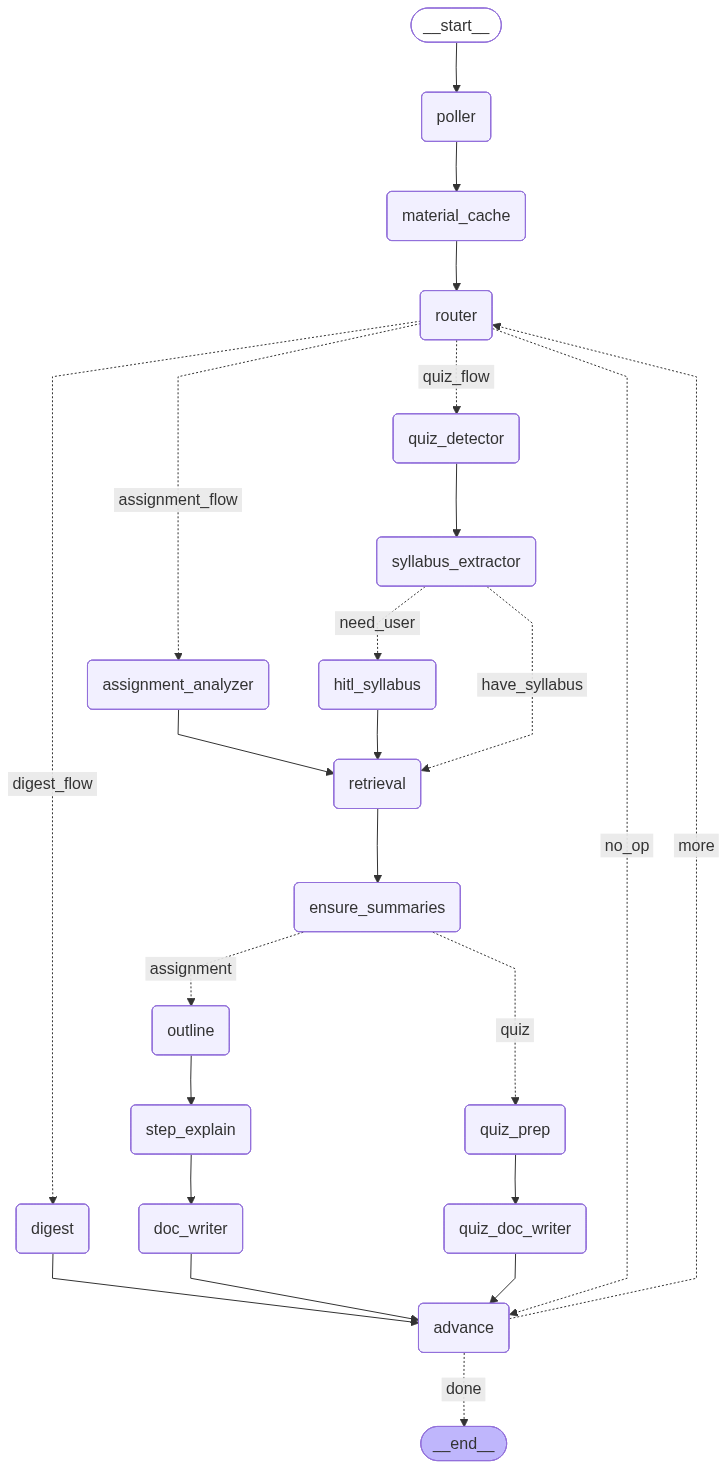

In [34]:
from IPython.display import Image, display
from pathlib import Path

# app is the compiled graph
g = app.get_graph()

# Try PNG rendering
try:
    png_bytes = g.draw_mermaid_png()
    display(Image(png_bytes))
except Exception as e:
    print("PNG render failed, showing Mermaid source instead:")
    print(g.draw_mermaid())

In [35]:
state = WFState(course_id=COURSE_ID)
out = app.invoke(state)
out

[07:58:36] poller.done new_events=12
[07:58:45] summaries.ensured count=0
[07:58:47] router.decide task_type=assignment_flow confidence=1.0 title=Assignment 1 text=You have learnt the neighbourhood based models in this class so far. Your assignment will be to combine user-based and i
[07:58:49] assignment.analyzed coding=coding
[07:58:49] retrieval.done query=Combine user-based and item-based approaches, Use MovieLens 100K dataset, Submit PDF explaining approach, Submit runnable Python code hits=5
[07:58:49] summaries.ensured count=5
[07:58:55] outline.generated sections=8
[07:59:05] step_explain.done count=1
[07:59:15] step_explain.done count=2
[07:59:24] step_explain.done count=3
[07:59:34] step_explain.done count=4
[07:59:44] step_explain.done count=5
[07:59:53] step_explain.done count=6
[07:59:59] step_explain.done count=7
[08:00:07] step_explain.done count=8
[08:00:07] doc_writer.start event_id=coursework:824539631700
PDF generated: cache_files/coursework:824539631700.pdf
[08:01:2

{'course_id': '793157523744',
 'new_event_ids': [],
 'current_event_id': None,
 'task_type': '',
 'topics_query': 'Naive Bayes filtering',
 'selected_material_ids': ['drive:1oGsGMZb0JOGviTGG_88VfNr9cAqG-rm7',
  'drive:11uu-5bUXN-BnDPPBi_LwO8xrAlH8LeRo',
  'drive:1021D-GYykKeBIQXep_bcyGCYuYVT2qzB',
  'drive:13IWyX9cnBYBtlJzy0NE--EcuXAYM1Xef',
  'drive:11_by7_QJvkyOz55FDLChRa-LJS9UqmOt'],
 'debug': {'poller': {'new_events': ['coursework:824539631700',
    'coursework:825301131030',
    'announcement:838886122709',
    'announcement:839401000329',
    'announcement:840142327698',
    'announcement:824535953547',
    'announcement:840716839875',
    'announcement:842686817838',
    'announcement:843419013736',
    'announcement:793656175280']},
  'ensure_summaries': {'ensured': ['drive:1oGsGMZb0JOGviTGG_88VfNr9cAqG-rm7',
    'drive:11uu-5bUXN-BnDPPBi_LwO8xrAlH8LeRo',
    'drive:1021D-GYykKeBIQXep_bcyGCYuYVT2qzB',
    'drive:13IWyX9cnBYBtlJzy0NE--EcuXAYM1Xef',
    'drive:11_by7_QJvkyOz55FDL